In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

import seaborn as sns

from sklearn.datasets import make_classification

from bertopic import BERTopic

import torch
from torch import nn
import torch.nn.functional as F

In [3]:
# load the data

PUBMED_PATH = Path('data/pubmed_abstracts_preprocessed.csv.gz')
MODEL_NAME = 'pubmed1pct_bertopic'
VERSION = 'v202109291'

indices = np.load(f'outputs/models/{MODEL_NAME}_{VERSION}.idx.npz')['arr_0']
model: BERTopic = BERTopic.load(f'outputs/models/{MODEL_NAME}_{VERSION}.model')
topics = np.load(f'outputs/models/{MODEL_NAME}_{VERSION}.topics.npz')['arr_0']
probs = np.load(f'outputs/models/{MODEL_NAME}_{VERSION}.probs.npz')['arr_0']

PUBMED = pd.read_csv(PUBMED_PATH)
PUBMED = PUBMED[PUBMED.index.isin(indices)]
PUBMED['label'] = PUBMED['subcategory'].astype('category')

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# DEBUG simulated dataset
# n_topics = 300
# n_samples = 1000
# n_labels = 10
# X, y = make_classification(n_samples=n_samples, n_features=n_topics, n_classes=n_labels, n_informative=10, random_state=0)


# Tensorboard logger
logger = SummaryWriter()

# training parameter
n_epoches = 1000
batch_size = 1000

# prepare the X and y and parameters
X = probs
y = PUBMED['label'].cat.codes.values
n_topics = X.shape[1]
n_samples = X.shape[0]
n_labels = y.max() + 1
train_size = int(n_samples * .9)
test_size = n_samples - train_size

# prepare the test/train datasets
X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.long)
dataset = TensorDataset(X, y)
train_subset, test_subset = random_split(dataset, lengths=(train_size, test_size))
X_test, y_test = dataset[test_subset.indices]

model = nn.Sequential(
  nn.Embedding(n_labels, n_topics)
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

logger.add_graph(model, y)

trace = []

for epoch in tqdm(range(n_epoches)):

  model.train()
  for X_batch, y_batch in DataLoader(train_subset, batch_size=batch_size, shuffle=True):
    model.zero_grad()
    X_pred = model(y_batch)
    loss = criterion(X_batch, X_pred)
    logger.add_scalar('loss/train', loss.detach(), epoch)
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    X_pred = model(y_test)
    loss = criterion(X_test, X_pred)
    logger.add_scalar('loss/test', loss.detach(), epoch)


100%|██████████| 1000/1000 [00:26<00:00, 38.36it/s]


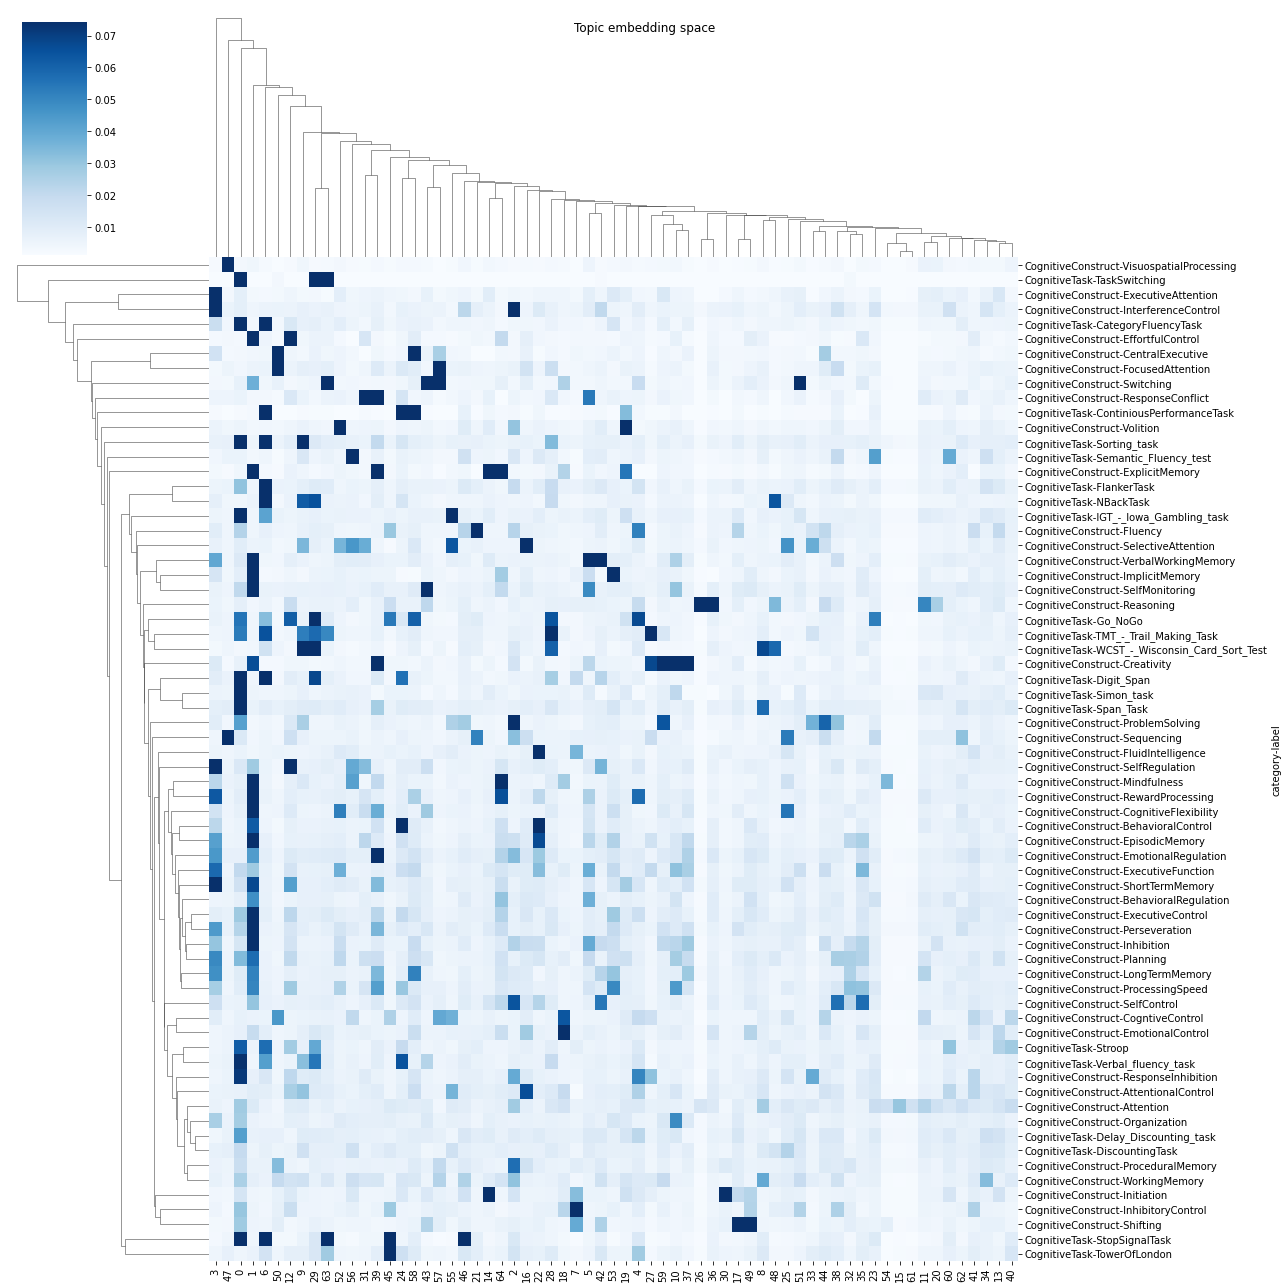

In [25]:

# convert to a dataframe, indexed by label and category
H = pd.DataFrame(next(model.parameters()).detach().numpy())
labels = PUBMED['label'].cat.categories[H.index]
categories = labels.to_series().apply(lambda lbl: PUBMED.query('label == @lbl')['category'].unique().item())
indices = categories.to_frame().reset_index().rename(columns={0: 'category', 'index': 'label'})
H.index = pd.MultiIndex.from_frame(indices).reorder_levels(['category', 'label'])

sns.clustermap(H, figsize=(18, 18), cmap='Blues', robust=True)
plt.suptitle('Topic embedding space')
plt.show()

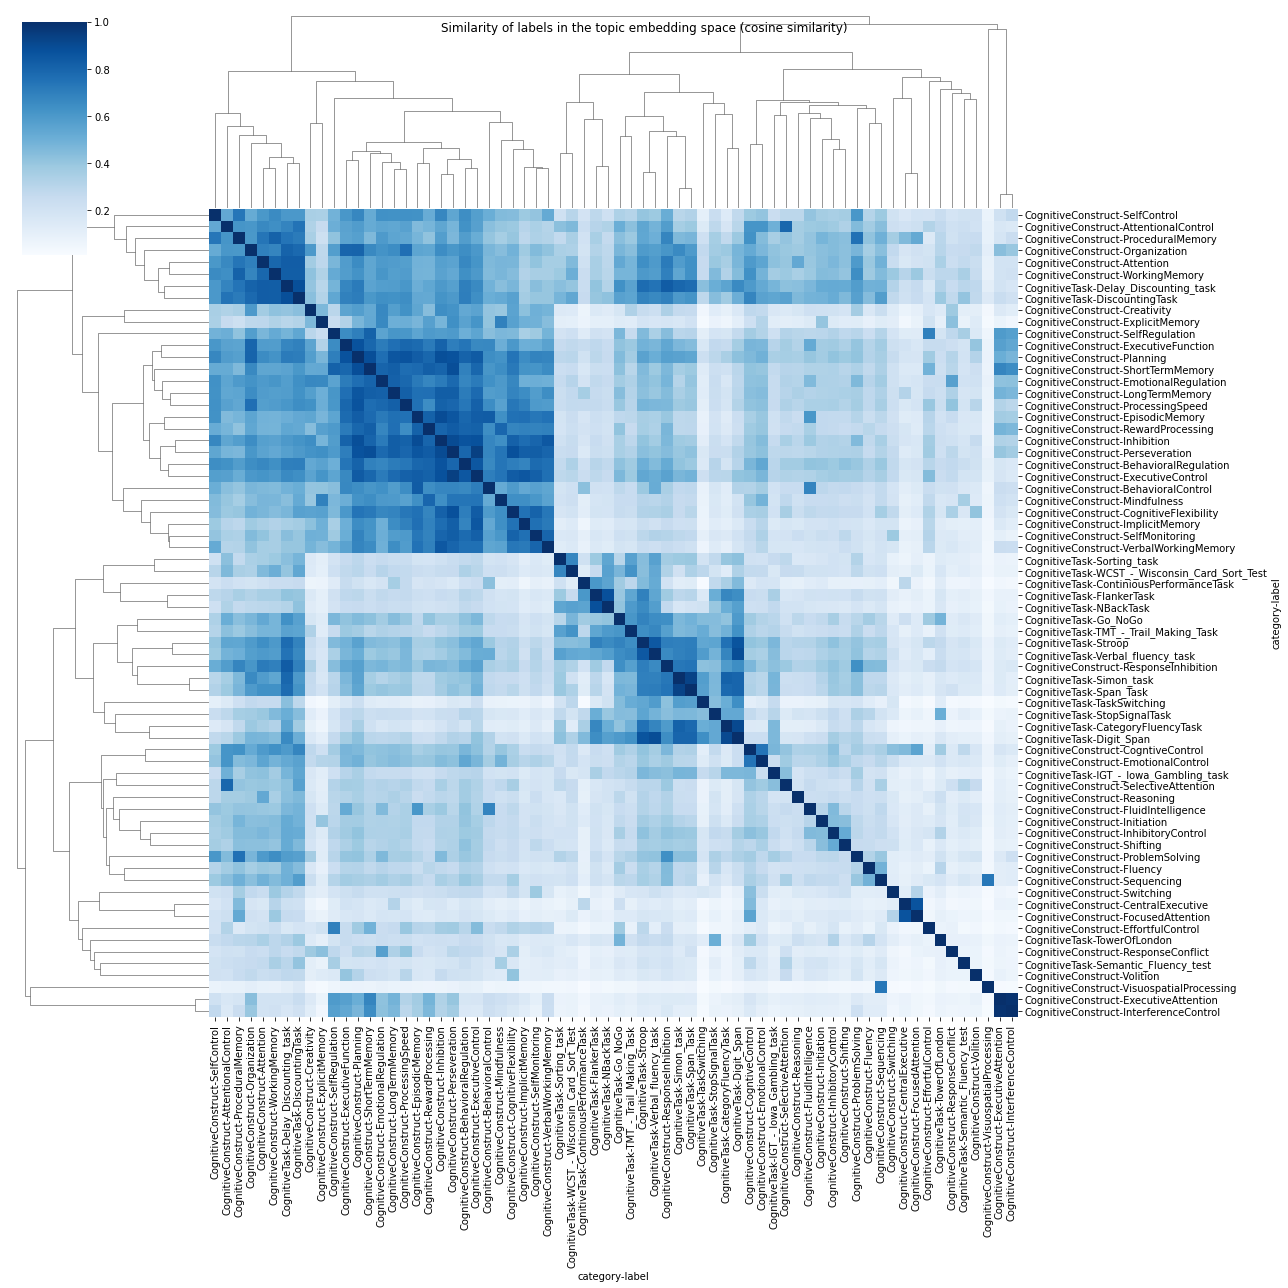

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
H_sim = pd.DataFrame(cosine_similarity(H), columns=H.index, index=H.index)
sns.clustermap(H_sim, cmap='Blues', figsize=(18,18))
plt.suptitle('Similarity of labels in the topic embedding space (cosine similarity)')
plt.show()

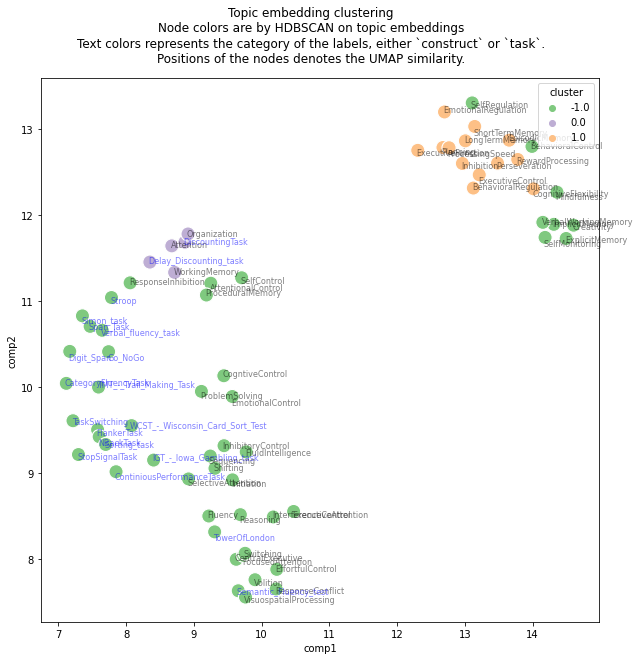

In [69]:
import hdbscan
import umap
from sklearn.decomposition import PCA


H_projection = umap.UMAP(n_components=2, random_state=0).fit_transform(H_sim)
# H_projection = PCA(n_components=2, random_state=0).fit_transform(H)

clusters = hdbscan.HDBSCAN().fit_predict(H_sim).reshape(-1,1)

cat_colors_palette = ['black','blue']
cat_colors = H.index.to_frame()['category'].astype('category').cat.codes.to_list()
cat_colors = [cat_colors_palette[c] for c in cat_colors]

H_projection = np.hstack((H_projection, clusters))

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.scatterplot(
    data=pd.DataFrame(H_projection, columns=['comp1', 'comp2', 'cluster']),
    x='comp1', y='comp2', hue='cluster', ax=ax, palette='Accent', s=200)

for (cat, lbl), (x, y, c), color in zip(H.index.to_list(), H_projection, cat_colors):
    ax.text(x-0.02, y-np.random.random()*.1, f'{lbl}', alpha=0.5, fontsize=8, color=color)

plt.suptitle(
    'Topic embedding clustering\n'
    'Node colors are by HDBSCAN on topic embeddings\n'
    'Text colors represents the category of the labels, either `construct` or `task`.\n'
    'Positions of the nodes denotes the UMAP similarity.')
plt.show()
